## Import Libraries

In [5]:
import os

os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [ ]:
import os
import time
import shutil
import pathlib
import itertools
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns

import cv2
from imageio import imread
import matplotlib.pyplot as plt

from dotenv import load_dotenv
from matplotlib.ticker import MaxNLocator

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
# from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


%matplotlib inline

## Utility functions

In [7]:
def save_webcam_image(img_path):
    camera = cv2.VideoCapture(0)  # Open webcam (0 = default webcam)
    
    if not camera.isOpened():
        print("❌ Webcam not found or not accessible.")
        return False  # Return False if webcam is not available

    retval, im_camera = camera.read()

    if not retval:  # Check if an image was captured successfully
        print("❌ Failed to capture image from webcam.")
        return False  

    im = cv2.resize(im_camera, (224, 224)).astype(np.float32)  # Resize image
    cv2.imwrite(img_path, im)  # Save image
    camera.release()  # Release the webcam
    return True  # Return True if image is saved successfully

In [8]:
def predict_image(model, img_path, preprocess_input_fn, decode_predictions_fn, target_size=(224, 224)):

    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input_fn(x)
    
    preds = model.predict(x)
    predictions_df = pd.DataFrame(decode_predictions_fn(preds, top=5)[0])
    predictions_df.columns = ["Predicted Class", "Name", "Probability"]
    return predictions_df

In [9]:
def display_image_prediction(model, img_path, preprocess_input, decode_predictions_fn):
    # Check if img_path not found
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"Image path not found: ".format(img_path))
    # Load the image for display
    img = Image.open(img_path)
    # Make predictions
    predictions = predict_image(model, img_path, preprocess_input, decode_predictions_fn)
    # Display the image and predictions
    plt.figure(figsize=(8, 6))  # Adjust figure size as needed
    plt.imshow(img)
    plt.title(f"Predictions for {img_path}")
    plt.axis('off')  # Turn off axis ticks and labels

    # Display top 5 predictions as text on the plot
    prediction_text = "\n".join([f"{name}: {prob:.6f}" for _, name, prob in predictions.values[:5]])  # Show top 5 predictions
    plt.text(0.05, 0.05, prediction_text, transform=plt.gca().transAxes, fontsize=8, color='white',
                bbox=dict(facecolor='black', alpha=0.5))

    plt.show()

In [10]:
def track_performance(history):
  fig = plt.figure(figsize=(14, 5), dpi=80)
  ax = fig.add_subplot(1, 2, 1)
  ax.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax.plot(history.history['loss'])
  ax.plot(history.history['val_loss'])
  ax.set_title('Loss')
  ax.set_ylabel('loss')
  ax.set_xlabel('epoch')
  ax.legend(['train', 'val'], loc='upper right')

  ax = fig.add_subplot(1, 2, 2)
  ax.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax.plot(history.history['accuracy'])
  ax.plot(history.history['val_accuracy'])
  ax.set_title('Accuracy')
  ax.set_ylabel('accuracy')
  ax.set_xlabel('epoch')
  ax.legend(['train', 'val'], loc='lower right')

## Show Example Picture

C:\Users\cartoongummy\AppData\Local\Temp\ipykernel_18252\1324635844.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plt.imshow(imread(img_path))


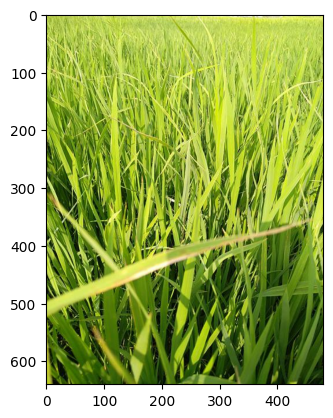

In [11]:
load_dotenv()
img_path = os.getenv('IMG_PATH')

plt.imshow(imread(img_path))

## Preparing Data for training

### Load Image Data such as paths and labels

In [ ]:
data_path = '../Data/train_images'

# สร้างลิสต์ images & labels เพื่อเก็บ path ของรูป และ ชื่อ subfolder(บ่งบอกชื่อคลาส)
images = []
labels = []

for subfolder in os.listdir(data_path):
    subfolder_path = os.path.join(data_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue
    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
        labels.append(subfolder)
    
data = pd.DataFrame({'image':images, 'labels':labels})
# แสดงตัวอย่างข้อมูลที่ถูกเก็บอยู่ใน data หลังจากที่เปลี่ยนจากลิสต์มาเป็น dataframe
print(data.iloc[0:4])

### Split the dataset into training set and validation set

In [ ]:
# แสดงจำนวนข้อมูล
df_all_rows = data.all(axis=1)
num_datas = len(df_all_rows)

print(num_datas)

In [ ]:
big_data = data['label']
# แบ่งข้อมูลทั้งหมดโดยแบ่งให้ 80% สำหรับการเทรน 20% สำหรับ validation และ test
train_df, temp_df = train_test_split(data, train_size=0.80, shuffle=True, random_state=123, stratify=big_data)

minor_data = temp_df['label']
val_df, test_df = train_test_split(temp_df, train_size=0.40, shuffle=True, random_state=123, stratify=minor_data)

In [ ]:
train_all_rows = train_df.all(axis=1)
train_all_rows = len(train_all_rows)

val_all_rows = val_df.all(axis=1)
val_all_rows = len(val_all_rows)

test_all_rows = test_df.all(axis=1)
test_all_rows = len(test_all_rows)

print(f"Train: {train_all_rows}")
print(f"Val: {val_all_rows}")
print(f"Test: {test_all_rows}")

## Use Pretrained Model


In [12]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [13]:
resnet50_model = ResNet50(weights = 'imagenet')

In [14]:
resnet50_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [15]:
predict_image(resnet50_model, img_path, preprocess_input, decode_predictions)

1/1 [==============================] - 2s 2s/step


,Predicted Class,Name,Probability
0,n02231487,walking_stick,0.166899
1,n13133613,ear,0.062429
2,n03649909,lawn_mower,0.039439
3,n03991062,pot,0.034469
4,n07714571,head_cabbage,0.032855


1/1 [==============================] - 0s 35ms/step


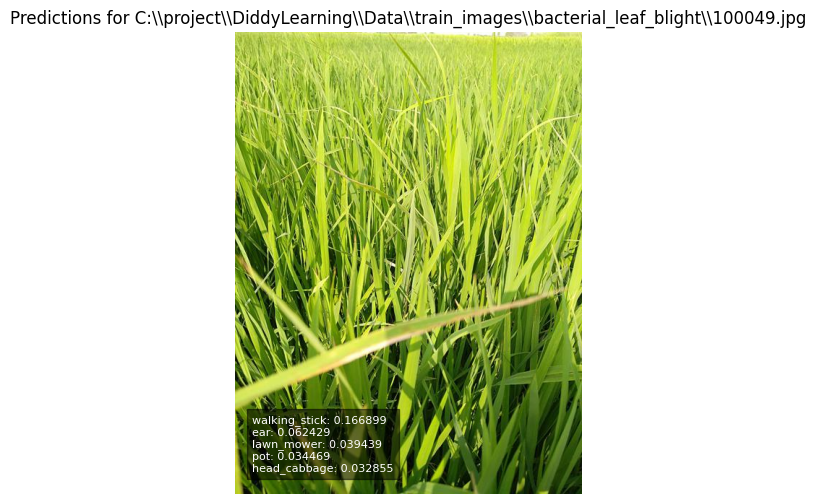

In [16]:
display_image_prediction(resnet50_model, img_path, preprocess_input, decode_predictions)

## Train Model for new 10 Classes

In [18]:
'''
Bacterial_leaf_blight => โรคขอบใบแห้ง
Bacterial_leaf_streak => โรคขีดใบโปร่งแสง
Bacterial_panicle_blight => โรคกาบใบแห้ง
Blase => โรคไหม้
Brown_spot => โรคใบจุดสีน้ำตาล
Dead_heart => โรคยอดเหี่ยว
Downy_mildew => โรคราน้ำค้าง
Hispa => โรคแมลงกัดใบข้าว
Normal => ปกติ
Tungro => โรคใบสีส้ม
'''

num_classes = ['bacterial_leaf_blight', 'bacterial_leaf_streak',
 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart',
 'downy_mildew', 'hispa', 'normal', 'tungro']

In [19]:
# สร้าง Fully Connected Layer ใหม่
x = Flatten()(resnet50_model.output)  # แปลง Feature Maps เป็น Vector
x = Dense(512, activation='relu')(x)  # Fully Connected Layer
# x = Dropout(0.5)(x)  # comment ไว้ก่อน ตอนรันครั้งแรก ERROR
output = Dense(len(num_classes), activation='softmax')(x)  # Output Layer (10 Classes)

# สร้างโมเดลใหม่
new_model = Model(inputs=resnet50_model.input, outputs=output)


In [20]:
'''Arguments

initial_learning_rate: A Python float. The initial learning rate.
decay_steps: How often to apply decay.
decay_rate: A Python number. The decay rate.
staircase: Whether to apply decay in a discrete staircase, as o pposed to continuous, fashion.
name: String. Optional name of the operation. Defaults to "InverseTimeDecay". 

'''

lr_scheduler = tf.keras.optimizers.schedules.InverseTimeDecay(0.001, decay_rate=1e-6, decay_steps=1, staircase = False)

opt = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)

new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# สร้าง ImageDataGenerator สำหรับเพิ่มข้อมูลผ่าน Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=20, 
    width_shift_range=0.2, 
    height_shift_range=0.2,
    fill_mode = 'wrap', # เนื่องจากว่าเรามีการ shift ภาพ ดังนั้นเราจึงจะเติมส่วนที่หายไปจากการ shift ด้วย wrap 
    horizontal_flip=True, 
    validation_split=0.2  # แบ่ง Validation 20%
)

test_datagon = ImageDataGenerator()

# โหลดข้อมูล Training และ Validation
'''
train_generator = train_datagen.flow_from_directory(
    '../Data/train_images',  # เปลี่ยนเป็น path ของคุณ
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    '../Data/train_images',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)
'''
train_generator = train_datagen.flow_from_datafrme(
    train_df,
    x_col = 'image',
    y_col = 'label',
    target_size=(224, 224),
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle = True,
    batch_size = 32
)

val_generator = test_datagon.flow_from_dataframe(
    val_df,
    x_col = 'image',
    y_col = 'label',
    target_size=(224, 224),
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle = False,
    batch_size = 32
)

test_generator = test_datagon.flow_from_dataframe(
    test_df,
    x_col = 'image',
    y_col = 'label',
    target_size=(224, 224),
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle = False,
    batch_size = 32
)

Found 8330 images belonging to 10 classes.
Found 2077 images belonging to 10 classes.


In [ ]:

print("Train data:", train_generator.samples)
print("Validation data:", val_generator.samples)


Train data: 8330
Validation data: 2077


In [23]:
history = new_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,  # ปรับจำนวนรอบการ Train ตามต้องการ
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)



Epoch 1/15
261/261 [==============================] - 210s 772ms/step - loss: 2.1309 - accuracy: 0.2167 - val_loss: 2.1742 - val_accuracy: 0.1502
Epoch 2/15
261/261 [==============================] - 184s 706ms/step - loss: 1.9186 - accuracy: 0.3251 - val_loss: 2.6239 - val_accuracy: 0.1695
Epoch 3/15
261/261 [==============================] - 194s 744ms/step - loss: 1.7910 - accuracy: 0.3816 - val_loss: 2.7636 - val_accuracy: 0.1531
Epoch 4/15
261/261 [==============================] - 191s 733ms/step - loss: 1.6590 - accuracy: 0.4268 - val_loss: 2.3079 - val_accuracy: 0.2532
Epoch 5/15
261/261 [==============================] - 198s 758ms/step - loss: 1.4846 - accuracy: 0.4837 - val_loss: 1.7542 - val_accuracy: 0.4025
Epoch 6/15
261/261 [==============================] - 194s 742ms/step - loss: 1.4064 - accuracy: 0.5176 - val_loss: 2.0135 - val_accuracy: 0.3823
Epoch 7/15
261/261 [==============================] - 192s 736ms/step - loss: 1.2825 - accuracy: 0.5562 - val_loss: 1.7182 -

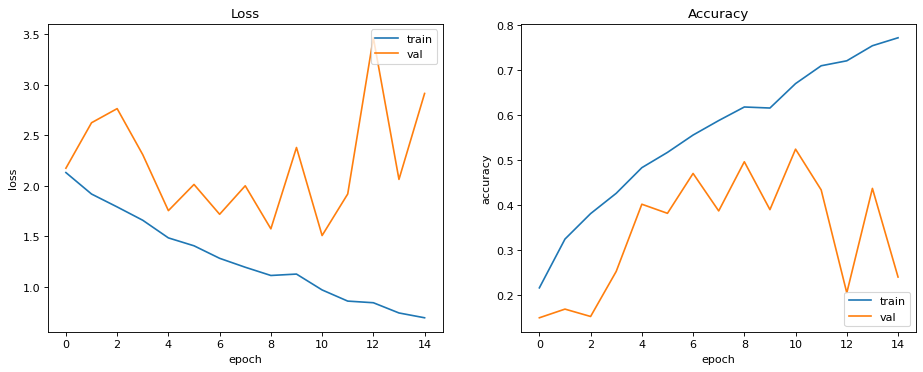

In [24]:
track_performance(history)

# Fine-Tuning

In [ ]:
# Unfreeze Layers ตั้งแต่ Block ที่ 3 เป็นต้นไป
for layer in resnet50_model.layers[-30:]:
    layer.trainable = True

lr_scheduler = tf.keras.optimizers.schedules.InverseTimeDecay(1e-5, decay_rate=1e-6, decay_steps=1, staircase = False)

opt = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)

# Compile ใหม่ด้วย Learning Rate ที่ต่ำลง
new_model.compile(optimizer = opt, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Fine-Tuning โมเดล
history_fine_tune = new_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,  # เพิ่มรอบการ Train
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

Epoch 1/5
261/261 [==============================] - 184s 686ms/step - loss: 0.7363 - accuracy: 0.7586 - val_loss: 0.7185 - val_accuracy: 0.7708
Epoch 2/5
261/261 [==============================] - 177s 680ms/step - loss: 0.6467 - accuracy: 0.7851 - val_loss: 0.6617 - val_accuracy: 0.7857
Epoch 3/5
261/261 [==============================] - 177s 678ms/step - loss: 0.6215 - accuracy: 0.7980 - val_loss: 0.6195 - val_accuracy: 0.8012
Epoch 4/5
261/261 [==============================] - 177s 679ms/step - loss: 0.5900 - accuracy: 0.8118 - val_loss: 0.6182 - val_accuracy: 0.8079
Epoch 5/5
261/261 [==============================] - 181s 692ms/step - loss: 0.5843 - accuracy: 0.8088 - val_loss: 0.6089 - val_accuracy: 0.8098


In [ ]:
track_performance(history_fine_tune)

## Evaluation Model

### Evaluation

In [ ]:
train_score = new_model.evaluate(train_generator, verbose=1)
val_score = new_model.evaluate(val_generator, verbose=1)
test_score = new_model.evaluate(test_generator, verbose=1)

print(f"Train Loss: {train_score[0]:.3f}")
print(f"Train Accuracy: {train_score[1]:.3f}")
print("- "*20)
print(f"Val Loss: {val_score[0]:.3f}")
print(f"Val Accuracy: {val_score[1]:.3f}")
print("- "*20)
print(f"Test Loss: {test_score[0]:.3f}")
print(f"Test Accuracy: {test_score[1]:.3f}")

### Confustion Matrix

In [ ]:
# ดึงค่า y_actual มาจาก test_generator
y_actual = test_generator.classes

# หาค่า y_pred
y_pred_prob = new_model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

# คำนวณ Confusion Matrix
cm = confusion_matrix(y_actual, y_pred)

# สร้างกราฟ
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blue', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Classification Report

In [ ]:
print(classification_report(y_actual, y_pred, target_names=test_generator.class_indices.keys()))

## New Model Save!!!

In [28]:
new_model.save('../Model/resnet50_finetuned2.h5')